In [11]:
?UnscentedKalmanFilter

In [20]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline
from pykalman import UnscentedKalmanFilter


dims_params = 1 # dq
dims_augmented_state, dims_observations = dims_params+2, 1 # dx, dy
num_samples = 800
dt_sample = 0.2
dt_integrate = dt_sample
steps_per_sample = int(dt_sample//dt_integrate)

a, b, c = 0.7, 0.8, 3.

def f(state, noise):
    v = state
    z, w = noise
    new_state = ruku4([v,w],dt_integrate,vossFNint,z)
    return new_state

def g(state, noise):
    return state

    
ukf = UnscentedKalmanFilter(f,g,transition_covariance=0.015, 
                            observation_covariance=0.2*0.2*np.var(x0[0,:]*np.eye(dims_observations)))


(filtered_state_means, filtered_state_covariances) = ukf.filter(noisy_data)
# (smoothed_state_means, smoothed_state_covariances) = ukf.smooth([0, 1, 2])

LinAlgError: 1-th leading minor not positive definite

In [8]:
def vossFNint(variables,params):
    '''Fitzhugh-Nagumo model'''
    a, b, c = 0.7, 0.8, 3.
    v, w = variables
    input_current = params.reshape(v.shape)
    return np.array([c*(w+v-v**3/3+input_current), -(v-a+b*w)/c]);

def ruku4(x0,dt_integrate,function,params):
    '''Runge-Kutta integrator - 4th order'''
    for i in range(steps_per_sample):
        k1 = dt_integrate*function(x0,params)
        k2 = dt_integrate*function(x0+k1/2,params)
        k3 = dt_integrate*function(x0+k2/2,params)
        k4 = dt_integrate*function(x0+k3,params)
        x0 += k1/6. + k2/3. + k3/3. + k4/6.
    return x0

def vossFNobsfct(augmented_state):
    return augmented_state[-2,:]

# Preallocate arrays
x0 = np.zeros((2,num_samples)) # true trajectory
xhat = np.zeros((dims_augmented_state,num_samples)) # estimated trajectory
Pxx = np.zeros((dims_augmented_state,dims_augmented_state,num_samples)) # covariance in x
errors = np.zeros((dims_augmented_state, num_samples))
Ks = np.zeros((dims_augmented_state,dims_observations,num_samples))

# Initial conditions
x0[:,0] = [0.,0.]

# External input current, estimated as parameter p later
Iext = np.arange(1,num_samples+1)/250.*2*np.pi
Iext = -0.4 - 1.01*(np.abs(np.sin(Iext/2.)))

for n in range(num_samples-1):
    x_temp = x0[:,n]
    x0[:,n+1] = ruku4(x_temp,dt_integrate,vossFNint,Iext[n])
    
augmented_state = np.vstack((Iext,x0))
xhat[:,0] = augmented_state[:,0]

# Covariances
process_noise = 0.015
observation_noise = 0.2*0.2*np.var(vossFNobsfct(augmented_state))*np.eye(dims_observations)

noisy_data = vossFNobsfct(augmented_state) + np.matmul(la.sqrtm(observation_noise),
                                   np.random.randn(dims_observations,num_samples))

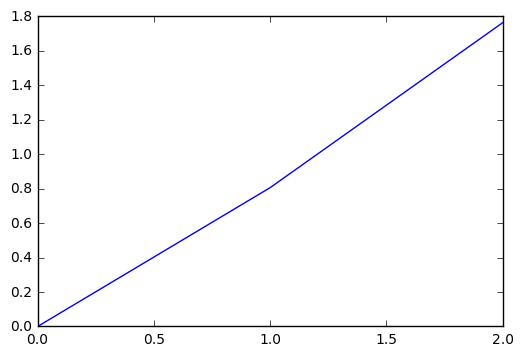

In [4]:
plt.plot(filtered_state_means)